# Extra lab 1 - Basics of Autograd in Python

In this extra laboratory, we will learn a few concepts about autograd in PyTorch and how to build modules with a custom backward pass.

## Building a custom non-parametric module

Basically, we want to create a module which is not controlled by any parameter, be it trainable or non-trainable.

As an example, we might have the Leaky ReLU, an activation function which can be used in place of the more-known ReLU.

$\text{Leaky_ReLU} = \max\{0.01\cdot x, x\}$

![](https://i1.wp.com/clay-atlas.com/wp-content/uploads/2019/10/image-37.png?resize=640%2C480&ssl=1)

We could do it with the basic PyTorch Tensor methods, like we did at the end of Lab2. Suppose though that, for any reason, we did not have an automatic gradient calculation: we would need to build an autograd Function to implement our Leaky ReLU.

In [51]:
import torch
from matplotlib import pyplot as plt

An autograd Function inherits from `torch.autograd.Function` and has two compulsory methods: `forward` and `backward`, whose meaning should be obvious to all.

Both functions have a compulsory first argument which is the **context**, `ctx` for brevity.
From the context we can infer informations about the entities involved in the calculation of the gradient.
The context is built upon calling the `forward` method, so that, during the `backward` call, we can obtain the info such what tensors have been used in `forward` and whether a tensor requires or not the grad.

Moreover, the backward method needs an additional argument, `output_grad`, which conveys information about the gradient which is _entering_ the Function (be mindful, we're running _backward_, so a gradient _enters the function_ upstream w.r.t. the forward pass).

In [2]:
class LeakyReLU_Fun(torch.autograd.Function):
    @staticmethod # mind the decorator
    def forward(ctx, input_):
        ctx.save_for_backward(input_) # the parameters that will be involved in the gradient
        return torch.max(input_, input_ * 0.01)
    
    @staticmethod
    def backward(ctx, grad_output):
        input_, = ctx.saved_tensors # these are the variables which we need to backpropagate the gradient to (only the input)
        # the gradient is 1 for positive x's, 0.01 for negative x's
        grad_input = torch.ones_like(input_)
        grad_input[input_<0] = 0.01
        # now, we need to rescale for the grad_output
        grad_input *= grad_output
        '''
        a valid alternative (maybe better performing?):
        grad_input = grad_output.clone()
        grad_input[input_<0] *= 0.01
        '''
        return grad_input
        

In [4]:
fun = LeakyReLU_Fun.apply
x = torch.linspace(-5,5,11, requires_grad=True)
y = fun(x)
z = y.sum()
z.backward()

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])


In [5]:
x.grad

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])

In [6]:
class LeakyReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, X):
        return LeakyReLU_Fun.apply(X)

In [8]:
LeakyReLU()(x)

tensor([-0.0500, -0.0400, -0.0300, -0.0200, -0.0100,  0.0000,  1.0000,  2.0000,
         3.0000,  4.0000,  5.0000], grad_fn=<LeakyReLU_FunBackward>)

## Building a custom parametric module

We wish to extend our Leaky ReLU module to the Parametric ReLU: $\text{Param_ReLU} = \max\{\alpha\cdot x, x\}, x \in [0,1)$.

![](https://pytorch.org/docs/stable/_images/PReLU.png)

Parametric ReLU with $\alpha=0.25$

In [39]:
class ParamReLU_Fun(torch.autograd.Function):
    @staticmethod # mind the decorator
    def forward(ctx, input_, alpha:float):
        assert alpha >= 0 and alpha < 1, f"alpha should be >= 0 and < 1. Found {alpha}."
        ctx.save_for_backward(input_) # the parameters that will be involved in the gradient
        ctx.alpha = alpha # note that we don't use self.alpha
        return torch.max(input_, input_ * alpha)
    
    @staticmethod
    def backward(ctx, grad_output):
        input_, = ctx.saved_tensors # these are the variables which we need to backpropagate the gradient to (only the input)
        grad_input = grad_output.clone()
        grad_input[input_<0] *= ctx.alpha
        return grad_input, None

In [36]:
class ParamReLU(torch.nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, X):
        return ParamReLU_Fun.apply(X, self.alpha)

In [38]:
prelu = ParamReLU(0.25)
x = torch.linspace(-5,5,11, requires_grad=True)
y = prelu(x)
z = y.sum()
z.backward()
print(x.grad)

tensor([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
       requires_grad=True)
tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])


## Building a custom parametric module, with trainable parameters

What if our $\alpha$ within the parametric ReLU was a trainable parameter? I.e., what if the optimizer could upldate values of $\alpha$ during training?

In this case, we will not have a single parameter $\alpha$, but a vector $\mathbf{a}$ of the same size of the input of the function.

Moreover, we're not enforcing anymore a condition on $\mathbf{a}$, so we must extend our Parametric ReLU formula to encompass also the condition in which $\alpha<0$ or $\alpha>1$. The formula becomes:

$\text{Parametric_ReLU}(x) = \max(0, x) + \alpha \min(0, x)$

In [126]:
class ParamReLU_Trainable_Fun(torch.autograd.Function):
    @staticmethod # mind the decorator
    def forward(ctx, input_:torch.Tensor, alpha:torch.Tensor):
        # we are not enforcing anymore the condition on alpha
        ctx.save_for_backward(input_, alpha) # the parameters that will be involved in the gradient
        zeros = torch.zeros_like(input_)
        return torch.max(input_, zeros) + alpha * torch.min(input_, zeros)
    
    @staticmethod
    def backward(ctx, grad_output):
        input_, alpha, = ctx.saved_tensors # these are the variables which we need to backpropagate the gradient to (only the input)
        grad_input = grad_output.clone()
        grad_input[input_<0] *= alpha.expand_as(input_)[input_<0]
        
        # gradient of alpha - note that the funciton param_relu(a) is constant for positive input_ -> zero derivative
        grad_alpha = grad_output.clone()
        grad_alpha[input_<0] *= input_[input_<0]
        grad_alpha[input_>=0] = 0
        return grad_input, grad_alpha

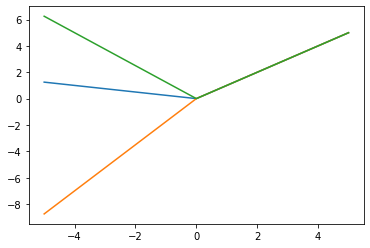

In [80]:
# plot the function for various "anomalous" levels of alpha
prelu_fun = ParamReLU_Trainable_Fun.apply
y1 = prelu_fun(x, torch.full_like(x, -0.25))
y2 = prelu_fun(x, torch.full_like(x, 1.75))
y3 = prelu_fun(x, torch.full_like(x, -1.25))
plt.plot(x.detach().numpy(), y1.detach().numpy())
plt.plot(x.detach().numpy(), y2.detach().numpy())
plt.plot(x.detach().numpy(), y3.detach().numpy())

In [119]:
class ParamReLU_Trainable(torch.nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.Tensor(in_features))
        self.alpha.data.uniform_(0, 1)
    
    def forward(self, X):
        return ParamReLU_Trainable_Fun.apply(X, self.alpha)

In [120]:
prelu = ParamReLU_Trainable(x.shape)
print(prelu.alpha)

Parameter containing:
tensor([0.2569, 0.0555, 0.2497, 0.2951, 0.6838, 0.0498, 0.6828, 0.5222, 0.9132,
        0.7173, 0.7872], requires_grad=True)


In [121]:
y = prelu(x)
print(y)

tensor([-1.2846, -0.2220, -0.7490, -0.5901, -0.6838,  0.0000,  1.0000,  2.0000,
         3.0000,  4.0000,  5.0000], grad_fn=<ParamReLU_Trainable_FunBackward>)


In [122]:
z = y.sum() * 2
z.backward()
print(prelu.alpha.grad)
print(x.grad)

torch.Size([11]) torch.Size([11]) torch.Size([11])
tensor([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   0.,   0.,   0.,   0.,   0.])
tensor([1.4488, 2.3287, 2.2010, 2.4278, 3.8587, 9.0000, 9.0000, 9.0000, 9.0000,
        9.0000, 9.0000])


Let us put this inside our MLP and see how things work out...

In [123]:
from scripts import train
from scripts import mnist

In [127]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28*28, 16),
            ParamReLU_Trainable(16),

            torch.nn.BatchNorm1d(num_features=16),
            torch.nn.Linear(16, 32),
            ParamReLU_Trainable(32),

            torch.nn.BatchNorm1d(num_features=32),
            torch.nn.Linear(32, 24),
            ParamReLU_Trainable(24),

            torch.nn.BatchNorm1d(num_features=24),
            torch.nn.Linear(24, 10)
        )
        
    def forward(self, X):
        return self.layers(X)

In [ ]:
net = MLP()

First, let us inspect alphas

In [ ]:
def inspect_alphas(net):
    for name, param in net.named_parameters():
        if "alpha" in name:
            print(name, "\n", param, "\n")
inspect_alphas(net)

Then, train our network...

In [128]:
optim = torch.optim.Adam(net.parameters())
loss = torch.nn.CrossEntropyLoss()
num_epochs = 5
trainloader, testloader, _, _ = mnist.get_data()
train.train_model(net, trainloader, loss, optim, num_epochs)

Epoch 1 --- learning rate 0.00100
Epoch 1 completed. Loss - total: 37716.54240274429 - average: 0.6286090400457383; Performance: 0.8542666666666666
Epoch 2 --- learning rate 0.00100
Epoch 2 completed. Loss - total: 14607.407104492188 - average: 0.24345678507486979; Performance: 0.9327166666666666
Epoch 3 --- learning rate 0.00100
Epoch 3 completed. Loss - total: 11235.904957771301 - average: 0.18726508262952168; Performance: 0.94485
Epoch 4 --- learning rate 0.00100
Epoch 4 completed. Loss - total: 9695.077285289764 - average: 0.16158462142149607; Performance: 0.9515166666666667
Epoch 5 --- learning rate 0.00100
Epoch 5 completed. Loss - total: 8750.21903371811 - average: 0.1458369838953018; Performance: 0.9556833333333333


(8750.21903371811, 0.9556833333333333)

In [130]:
train.test_model(net, testloader)

TESTING - loss -- - performance 0.9597833333333333


(None, 0.9597833333333333)

Actually, our model is not performing bad at all.

Let us check the values of the $\alpha$s after training:

In [135]:
inspect_alphas(net)

layers.2.alpha 
 Parameter containing:
tensor([ 0.3485,  0.2707,  0.5717,  0.3840,  0.9014,  0.1937,  0.2021,  0.4519,
         0.1335,  0.0046,  0.3972,  0.7110,  0.1408, -0.0292,  0.7536,  0.7141],
       requires_grad=True) 

layers.5.alpha 
 Parameter containing:
tensor([ 0.4110, -0.1313,  0.4857,  0.8699,  0.1633,  0.0103,  0.3908,  0.8189,
         0.7002,  0.3088, -0.0934,  0.6500,  0.1543, -0.1744,  0.5346,  0.1216,
         0.3257, -0.0638,  0.8712,  0.1859,  0.1993,  0.6637,  0.1628,  0.1634,
        -0.0183,  0.4822,  0.8188,  0.9636, -0.0750,  0.4852,  0.0674,  1.2015],
       requires_grad=True) 

layers.8.alpha 
 Parameter containing:
tensor([ 0.6490,  0.1644,  0.4802,  0.5110,  0.1363, -0.0082,  0.2481,  0.0915,
         0.9330, -0.0874,  0.3002,  0.2203,  0.4857,  0.0791,  0.5764,  0.4767,
         0.1953,  0.1956,  0.4838, -0.1792, -0.0680,  0.0226,  0.6703, -0.0442],
       requires_grad=True) 

